In [31]:
!pip install tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [32]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)

In [33]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 256
epochs = 30

In [34]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [35]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset, test_dataset = mnist(train_size, transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

In [28]:
def plotn(n, data, noisy=False, super_res=None):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break
        preprocess = z[0].reshape(1,28,28,) if z[0].shape[1] == 28 else z[0].reshape(1, 14, 14) if z[0].shape[1] == 14 else z[0]
        if  super_res is not None:
            _transform = transform.Resize((int(preprocess.shape[1] / super_res), int(preprocess.shape[2] / super_res)))
        if noisy:
            shapes = list(preprocess.shape)
            preprocess += noisify(shapes)
        ax[i].imshow(preprocess[0])
    plt.show()
    

In [29]:
def noisify(shapes):
    return np.random.normal(loc=0.5, scale=0.3, size=shapes)

In [30]:
plotn(5, train_dataset)

NameError: name 'train_dataset' is not defined

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3,3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3,3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv3 = nn.Conv2d(8, 8, kernel_size=(3,3), padding='same')
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2), padding=(1,1))
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        hidden2 = self.maxpool2(self.relu(self.conv2(hidden1)))
        encoded = self.maxpool3(self.relu(self.conv3(hidden2)))
        return encoded

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(8, 8, kernel_size=(3,3), padding='same')
        self.upsample1 = nn.Upsample(scale_factor=(2,2))
        self.conv2 = nn.Conv2d(8,8, kernel_size=(3,3), padding='same')
        self.upsample2 = nn.Upsample(scale_factor=(2,2))
        self.conv3 = nn.Conv2d(8, 16, kernel_size=(3, 3))
        self.upsample3 = nn.Upsample(scale_factor=(2, 2))
        self.conv4 = nn.Conv2d(16, 1, kernel_size=(3, 3), padding='same')
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        hidden1 = self.upsample1(self.relu(self.conv1(input)))
        hidden2 = self.upsample2(self.relu(self.conv2(hidden1)))
        hidden3 = self.upsample3(self.relu(self.conv3(hidden2)))
        decoded = self.sigmoid(self.conv4(hidden3))
        return decoded



In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, super_resolution=False):
        super().__init__()
        if not super_resolution:
            self.encoder = Encoder()
        else:
            self.encoder = SuperResolutionEncoder()
        self.decoder = Decoder()
    
    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [ ]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device, noisy=None, super_res=None):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            shapes = list(imgs.shape)

            if super_res is not None:
                shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                _transform = transforms.Resize((shapes[2], shapes[3]))
                imgs_transformed = _transform(imgs)
                imgs_transformed = imgs_transformed.to(device)

            imgs = imgs.to(device)
            labels = labels.to(device)

            if noisy is not None:
                noisy_tensor = noisy[0]
            else:
                noisy_tensor = torch.zeros(tuple(shapes)).to(device)

            if super_res is None:
                imgs_noisy = imgs + noisy_tensor
            else:
                imgs_noisy = imgs_transformed + noisy_tensor

            imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

            preds = model(imgs_noisy)
            loss = loss_fn(preds, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                shapes = list(imgs.shape)

                if super_res is not None:
                    shapes[2], shapes[3] = int(shapes[2] / super_res), int(shapes[3] / super_res)
                    _transform = transforms.Resize((shapes[2], shapes[3]))
                    imgs_transformed = _transform(imgs)
                    imgs_transformed = imgs_transformed.to(device)


                imgs = imgs.to(device)
                labels = labels.to(device)

                if noisy is not None:
                    test_noisy_tensor = noisy[1]
                else:
                    test_noisy_tensor = torch.zeros(tuple(shapes)).to(device)

                if super_res is None:
                    imgs_noisy = imgs + test_noisy_tensor
                else:
                    imgs_noisy = imgs_transformed + test_noisy_tensor

                imgs_noisy = torch.clamp(imgs_noisy, 0., 1.)

                preds = model(imgs_noisy)
                loss = loss_fn(preds, imgs)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()


In [ ]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████| 30/30 [26:25<00:00, 52.85s/it, train loss:=0.104, test loss:=0.104]


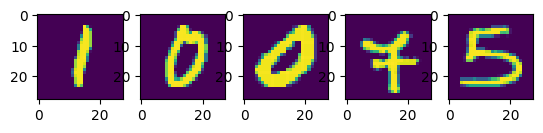

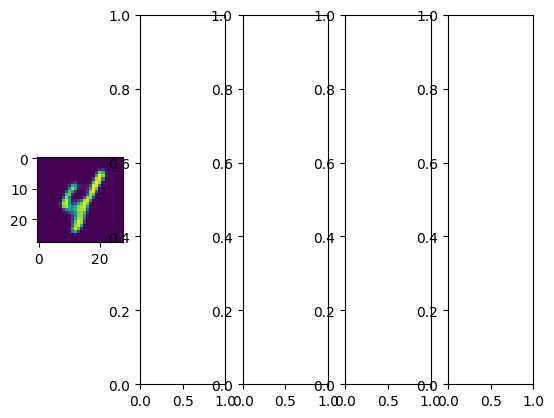

In [ ]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
predictions.append(model(data[0].to(device).unsqueeze(0)).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

In [ ]:
noisy_tensor = torch.FloatTensor(noisify([256, 1, 28, 28])).to(device)
test_noisy_tensor = torch.FloatTensor(noisify([1, 1, 28, 28])).to(device)
noisy_tensors = (noisy_tensor, test_noisy_tensor)

In [ ]:
train(dataloaders, model, loss_fn, optimizer, 100, device, noisy=noisy_tensors)

 27%|██▋       | 27/100 [25:03<1:10:34, 58.00s/it, train loss:=0.127, test loss:=0.123]

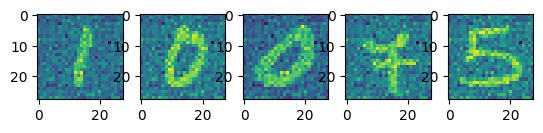

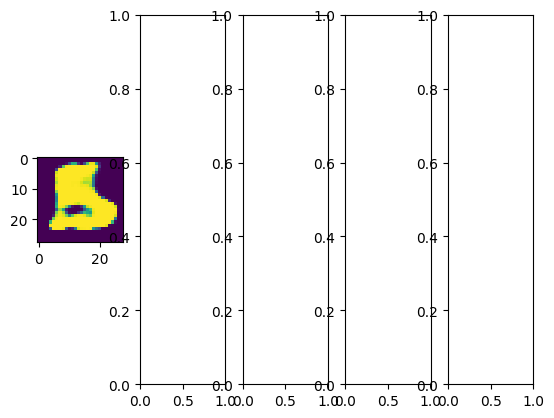

In [ ]:
model.eval()
predictions = []
noise = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    shapes = data[0].shape
    noisy_data = data[0] + test_noisy_tensor[0].detach().cpu()
    noise.append(noisy_data)
predictions.append(model(noisy_data.to(device).unsqueeze(0)).detach().cpu())
plotn(plots, noise)
plotn(plots, predictions)

AttributeError: 'Compose' object has no attribute 'Resize'

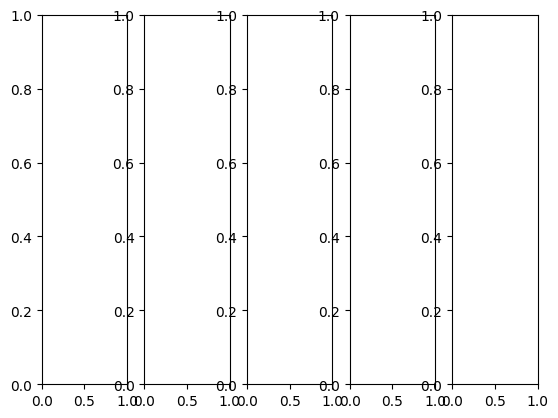

In [ ]:
super_res_koeff = 2.0
plotn(5, train_dataset, super_res=super_res_koeff)

In [ ]:
class SuperResolutionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3,3), padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(3, 3), padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()
    
    def forward(self, input):
        hidden1 = self.maxpool1(self.relu(self.conv1(input)))
        encoded = self.maxpool2(self.relu(self.conv2(hidden1)))
        return encoded

In [ ]:
model = AutoEncoder(super_resolution=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
loss_fn = nn.BCELoss()

In [ ]:


train(dataloaders, model, loss_fn, optimizer, epochs, device, super_res=2.0)

In [ ]:
model.eval()
predictions = []
plots = 5
shapes = test_dataset[0][0].shape

for i,data in enumerate(test_dataset):
    if i == plots:
        break
    _transform = transforms.Resize((int(shapes[1] / super_res_koeff), int(shapes[2] / super_res_koeff)))
predictions.append(model(_transform(data[0]).to(device).unsqueeze(0)).cpu())
plotn(plots, test_dataset, super_res=super_res_koeff)
plotn(plots, predictions)

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(784, self.intermediate_dim)
        self.z_mean = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.z_log = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.relu = nn.ReLU()
        self.device = device
    
    def forward(self, input):
        bs = input.shape[0]

        hidden = self.relu(self.linear(input))
        z_mean = self.z_mean(hidden)
        z_log = self.z_log(hidden)

        eps = torch.FloatTensor(np.random.normal(size=(bs,self.latent_dim))).to(device)
        z_val = z_mean + torch.exp(z_log) * eps
        return z_mean, z_log, z_val

In [ ]:
class VAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(self.latent_dim, self.intermediate_dim)
        self.output = nn.Linear(self.intermediate_dim, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        hidden = self.relu(self.linear(input))
        decoded = self.sigmoid(self.output(hidden))
        return decoded

In [ ]:
class VAEAutoEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.encoder = VAEEncoder(device)
        self.decoder = VAEDecoder()
        self.z_vals = None
    
    def forward(self, input):
        bs, c, h, w = input.shape[0], input.shape[1], input.shape[2], input.shape[3]
        input = input.view(bs, -1)
        encoded = self.encoder(input)
        self.z_vals = encoded
        decoded = self.decoder(encoded[2])
        return decoded

    def get_zvals(self):
        return self.z_vals

In [ ]:
def vae_loss(preds, targets, z_vals):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds, targets.view(targets.shape[0], -1)) * 784.0
    temp = 1.0 + z_vals[1] - torch.square(z_vals[0] - torch.exp(z_vals[1]))
    kl_loss = 0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [ ]:
model = VAEAutoEncoder(device).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=eps)

In [36]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            z_vals = model.get_zvals()
            loss = vae_loss(preds, imgs, z_vals)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                z_vals = model.get_zvals()
                loss = vae_loss(preds, imgs, z_vals)

                test_loss += loss.item()
        
        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [ ]:

train_vae(dataloaders, model, optimizer, epochs, device)

  0%|          | 0/30 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [03:20<10:05, 26.33s/it, train loss:=-2.06e+10, test loss:=-2.55e+10]